# EEG States
Training a model on manually labelled EEG data to find various states.

In [1]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import run_yasa
import logging
import mne
import yasa
import os
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter
log = lambda msg: logging.info(msg)


# Load data

In [2]:
input_dir = "C:\\dev\\play\\brainwave-data"
stats_df = pd.read_csv(input_dir + os.path.sep + "stats.csv")


In [3]:
from models.eeg_states.eeg_states import load_and_prepare_tired_wired_eeg_state_events

nights = load_and_prepare_tired_wired_eeg_state_events()

C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:115: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2024-10-09 20:17:27.992000+00:00' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  events.at[i, 'since'] = since_time
C:\dev\play\brainwave-processor\models\eeg_states\eeg_states.py:117: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  events['duration'] = events['timestamp'] - events['since']


In [4]:
nights

,event,version,phase,note,duration,TimestampUK,SinceUK,dayAndNightOf
0,tired_long,NaN,NaN,NaN,0 days 00:05:00,2024-10-09 21:22:27.992000+01:00,2024-10-09 21:17:27.992000+01:00,2024-10-09
1,tired,NaN,NaN,NaN,NaT,2024-10-09 21:28:57.046000+01:00,NaT,2024-10-09
2,tired,NaN,NaN,NaN,NaT,2024-10-09 21:32:36.824000+01:00,NaT,2024-10-09
3,tired_long,NaN,NaN,NaN,0 days 00:00:15.951000,2024-10-09 21:32:52.775000+01:00,2024-10-09 21:32:36.824000+01:00,2024-10-09
4,tired,NaN,NaN,NaN,NaT,2024-10-09 21:33:13.921000+01:00,NaT,2024-10-09
...,...,...,...,...,...,...,...,...
437,sleepy_long,v1,settling,NaN,0 days 00:00:57.114000,2024-11-20 21:33:35.168000+00:00,2024-11-20 21:32:38.054000+00:00,2024-11-20
438,tired,NaN,NaN,NaN,NaT,2024-11-20 21:39:45.419000+00:00,NaT,2024-11-20
439,sleepy,NaN,NaN,NaN,NaT,2024-11-20 21:41:05.764000+00:00,NaT,2024-11-20
440,sleepy,NaN,NaN,NaN,NaT,2024-11-20 21:43:13.344000+00:00,NaT,2024-11-20


In [5]:
for i in range(len(nights) - 1):
    if nights.loc[i, 'event'] == 'wired' and nights.loc[i + 1, 'event'] == 'tired':
        ts = nights.loc[i, 'TimestampUK']
        print(f"Wired event at index {i} {ts} is right next to a tired event at index {i + 1}")

Wired event at index 24 2024-10-10 06:38:03.185000+01:00 is right next to a tired event at index 25
Wired event at index 51 2024-10-20 20:51:41.078000+01:00 is right next to a tired event at index 52
Wired event at index 376 2024-11-17 21:07:11.480000+00:00 is right next to a tired event at index 377


In [6]:
nights['event'].value_counts()

event
tired          179
tired_long     107
wired_long      36
wired           34
sleepy_long     29
mid             26
sleepy          24
mid_long         7
Name: count, dtype: int64

In [7]:
nights['duration'].notna().sum()

179

## Load other data

In [8]:
import os

dfs = []

for root, dirs, files in os.walk(input_dir):
    for idx, dir_name in enumerate(dirs):
        input_file = os.path.join(root, dir_name, "raw.post_human.csv")
        if os.path.exists(input_file):
            df = pd.read_csv(input_file)
            dfs.append(df)

yasa_df = pd.concat(dfs, ignore_index=True)

In [9]:
yasa_df_orig = yasa_df.copy()
assert yasa_df.index.is_unique, "Index is not unique"

In [10]:
yasa_df.shape

(73189, 1625)

In [12]:
yasa_df['dayAndNightOf'].unique()

array(['2024-07-08', '2024-07-11', '2024-07-12', '2024-07-13',
       '2024-07-14', '2024-07-15', '2024-07-16', '2024-07-17',
       '2024-07-21', '2024-07-22', '2024-07-24', '2024-07-26',
       '2024-07-27', '2024-08-18', '2024-08-19', '2024-08-20',
       '2024-08-21', '2024-08-22', '2024-08-23', '2024-08-24',
       '2024-08-25', '2024-08-26', '2024-09-01', '2024-09-02',
       '2024-09-03', '2024-09-04', '2024-09-05', '2024-09-08',
       '2024-09-11', '2024-09-13', '2024-09-15', '2024-09-16',
       '2024-09-17', '2024-09-20', '2024-09-22', '2024-09-24',
       '2024-09-25', '2024-09-26', '2024-09-28', '2024-09-30',
       '2024-10-01', '2024-10-02', '2024-10-04', '2024-10-05',
       '2024-10-06', '2024-10-07', '2024-10-08', '2024-10-09',
       '2024-10-11', '2024-10-15', '2024-10-20', '2024-10-21',
       '2024-10-23', '2024-10-24', '2024-10-29', '2024-10-30',
       '2024-11-01', '2024-11-02', '2024-11-03', '2024-11-04',
       '2024-11-05', '2024-11-07', '2024-11-08', '2024-

In [13]:
yasa_df['dayAndNightOf'].value_counts()

dayAndNightOf
2024-09-24    2083
2024-08-19    1848
2024-09-03    1780
2024-08-20    1502
2024-10-11    1389
              ... 
2024-09-16     314
2024-07-08     310
2024-10-29     135
2024-11-03     105
2024-10-20      83
Name: count, Length: 68, dtype: int64

# Prepare data - find if in state

In [14]:
from sleep_events import convert_timestamps_to_uk

convert_timestamps_to_uk(yasa_df, 'Timestamp', 'TimestampUK')

In [15]:
from models.eeg_states.eeg_states import process_row
import pandas as pd
from tqdm import tqdm

# Pre-filter the data as it takes ages
first_timestamp_uk = nights['TimestampUK'].min()
filtered_yasa_df = yasa_df[yasa_df['TimestampUK'] >= first_timestamp_uk]

# Add new columns to yasa_df to store the epoch type
yasa_df = filtered_yasa_df.copy() # defragment
yasa_df['epoch_type'] = None
yasa_df['matched_event'] = None

# Iterate over each row in yasa_df
for i, yasa_row in tqdm(yasa_df.iterrows(), total=yasa_df.shape[0]):
    epoch_type, matched_night_event = process_row(yasa_row, nights)
    yasa_df.at[i, 'epoch_type'] = epoch_type
    yasa_df.at[i, 'matched_event'] = matched_night_event

100%|██████████| 20621/20621 [04:24<00:00, 77.92it/s] 


In [16]:
yasa_df['epoch_type'].value_counts()

epoch_type
tired     315
wired     141
mid        22
sleepy     21
Name: count, dtype: int64

In [17]:
from memory import garbage_collect

garbage_collect(log)

In [18]:
from models.eeg_states.eeg_states_model import tired_vs_wired_model_pipeline

models_and_data = [
    tired_vs_wired_model_pipeline('settling-tired-vs-wired-non-realtime', yasa_df, "epoch_type", False),
    tired_vs_wired_model_pipeline('settling-tired-vs-wired-realtime', yasa_df, "epoch_type", True),
]

['Main_eeg_abspow_s', 'Main_eeg_abspow_c7min_norm_s', 'Main_eeg_abspow_p2min_norm_s', 'Main_eeg_alpha_s', 'Main_eeg_alpha_c7min_norm_s', 'Main_eeg_alpha_p2min_norm_s', 'Main_eeg_alphaaa_s', 'Main_eeg_alphaaa_c7min_norm_s', 'Main_eeg_alphaaa_p2min_norm_s', 'Main_eeg_alphaab_s', 'Main_eeg_alphaab_c7min_norm_s', 'Main_eeg_alphaab_p2min_norm_s', 'Main_eeg_alphaabs_s', 'Main_eeg_alphaabs_c7min_norm_s', 'Main_eeg_alphaabs_p2min_norm_s', 'Main_eeg_alphaabsaa_s', 'Main_eeg_alphaabsaa_c7min_norm_s', 'Main_eeg_alphaabsaa_p2min_norm_s', 'Main_eeg_alphaabsab_s', 'Main_eeg_alphaabsab_c7min_norm_s', 'Main_eeg_alphaabsab_p2min_norm_s', 'Main_eeg_at_s', 'Main_eeg_at_c7min_norm_s', 'Main_eeg_at_p2min_norm_s', 'Main_eeg_auc_s', 'Main_eeg_auc_c7min_norm_s', 'Main_eeg_auc_p2min_norm_s', 'Main_eeg_beta_s', 'Main_eeg_beta_c7min_norm_s', 'Main_eeg_beta_p2min_norm_s', 'Main_eeg_betaabs_s', 'Main_eeg_betaabs_c7min_norm_s', 'Main_eeg_betaabs_p2min_norm_s', 'Main_eeg_db_s', 'Main_eeg_db_c7min_norm_s', 'Main_eeg_

In [19]:
from models.eeg_states.eeg_states_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(modelAndData: ModelAndData):
    X_train_to_sleep, X_val_to_sleep, y_train_to_sleep, y_val_to_sleep = train_test_split(modelAndData.X, modelAndData.y, test_size=0.2, random_state=42)
    modelAndData.X_train = X_train_to_sleep
    modelAndData.y_train = y_train_to_sleep
    modelAndData.X_val = X_val_to_sleep
    modelAndData.y_val = y_val_to_sleep

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

Training set size settling-tired-vs-wired-non-realtime: 399, validation set size: 100
Training set size settling-tired-vs-wired-realtime: 399, validation set size: 100


# Train Catboost model

In [20]:
from catboost import CatBoostRegressor

def train(md: ModelAndData):
    md.model = CatBoostRegressor(
        iterations=2000,                # Number of boosting iterations
        learning_rate=0.03,             # Learning rate
        depth=6,                        # Depth of the tree
        l2_leaf_reg=3,                  # L2 regularization term on weights
        early_stopping_rounds=50        # Early stopping rounds
    )
    log(f"Training model for {md.name}")
    md.model.fit(md.X_train, md.y_train, verbose=100)

for md in models_and_data:
    train(md)

0:	learn: 0.3200190	total: 115ms	remaining: 3m 49s
100:	learn: 0.1105701	total: 645ms	remaining: 12.1s
200:	learn: 0.0682178	total: 1.15s	remaining: 10.3s
300:	learn: 0.0467675	total: 1.92s	remaining: 10.8s
400:	learn: 0.0345483	total: 2.8s	remaining: 11.2s
500:	learn: 0.0250005	total: 3.66s	remaining: 10.9s
600:	learn: 0.0193965	total: 4.45s	remaining: 10.4s
700:	learn: 0.0150592	total: 5.09s	remaining: 9.44s
800:	learn: 0.0111598	total: 5.78s	remaining: 8.65s
900:	learn: 0.0087088	total: 6.46s	remaining: 7.88s
1000:	learn: 0.0066849	total: 7.12s	remaining: 7.11s
1100:	learn: 0.0052665	total: 7.75s	remaining: 6.33s
1200:	learn: 0.0041822	total: 8.43s	remaining: 5.61s
1300:	learn: 0.0034273	total: 9.12s	remaining: 4.9s
1400:	learn: 0.0027935	total: 9.74s	remaining: 4.16s
1500:	learn: 0.0022586	total: 10.4s	remaining: 3.45s
1600:	learn: 0.0018331	total: 11s	remaining: 2.74s
1700:	learn: 0.0014928	total: 11.6s	remaining: 2.04s
1800:	learn: 0.0012332	total: 12.2s	remaining: 1.35s
1900:	le

## Evaluate the model

Evaluation for model:  settling-tired-vs-wired-non-realtime
settling-tired-vs-wired-non-realtime Training Set Evaluation:
MAE: 0.0006815116956108845, MSE: 6.942798769343504e-07, RMSE: 0.0008332345869767712


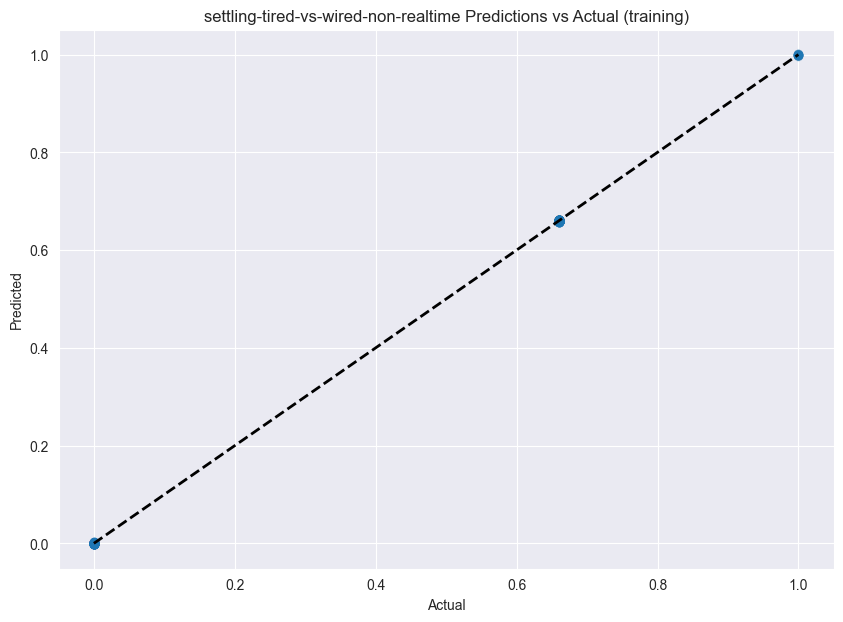

settling-tired-vs-wired-non-realtime Validation Set Evaluation:
MAE: 0.08698073142100324, MSE: 0.022618122260821966, RMSE: 0.1503932254485619


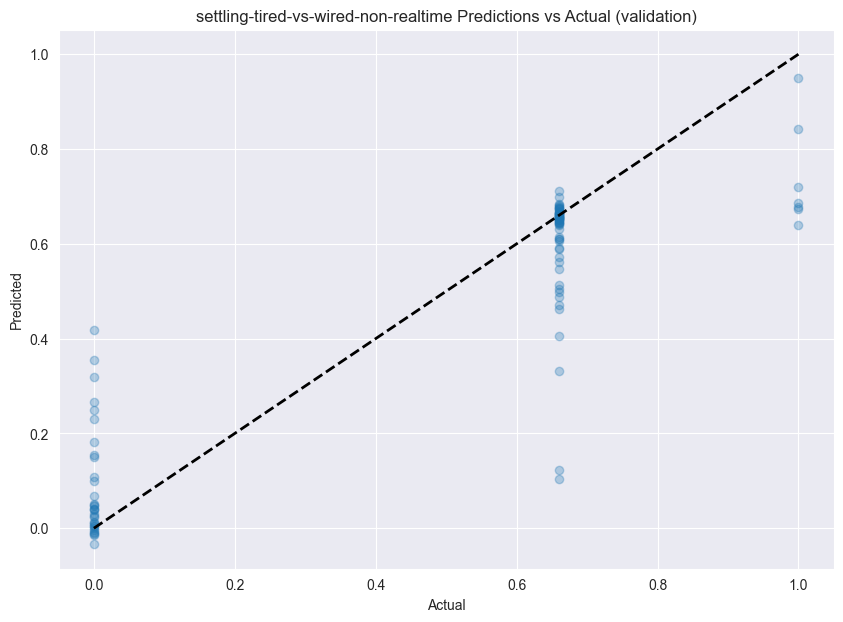

Evaluation for model:  settling-tired-vs-wired-realtime
settling-tired-vs-wired-realtime Training Set Evaluation:
MAE: 0.0022524747614642623, MSE: 7.952464049011878e-06, RMSE: 0.002820011356184914


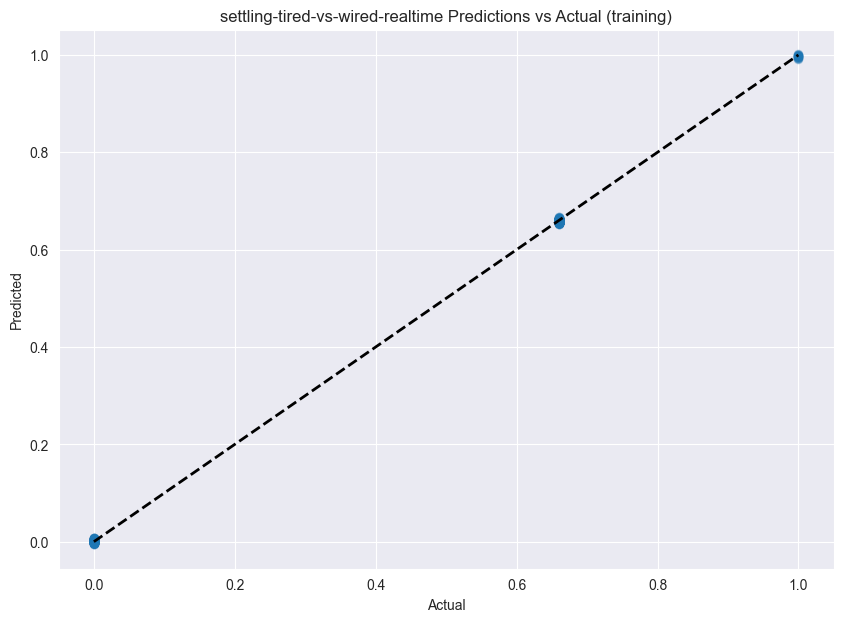

settling-tired-vs-wired-realtime Validation Set Evaluation:
MAE: 0.13368487580467542, MSE: 0.04457461091625428, RMSE: 0.21112700186440927


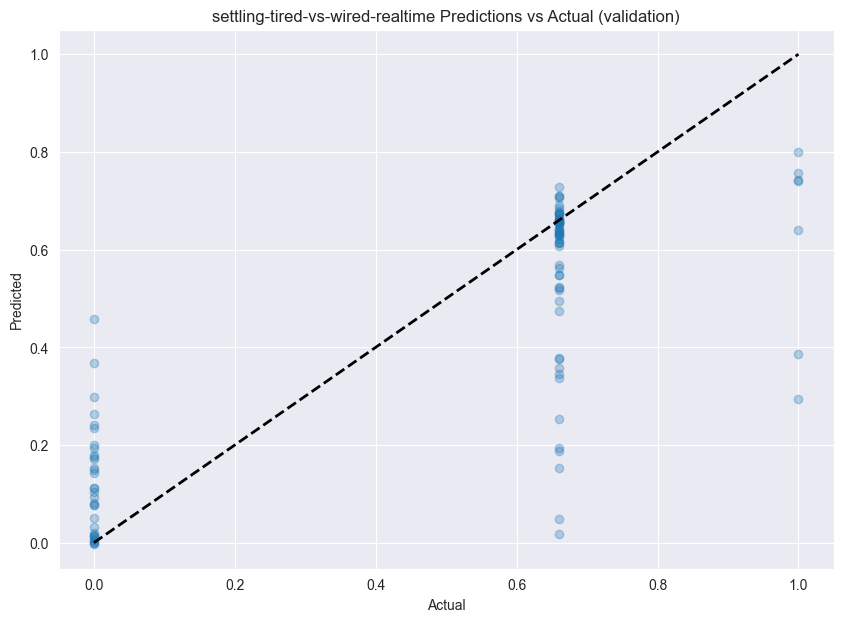

In [21]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def evaluate_model(md: ModelAndData, model, X, y):
    # Predict the target values using the trained model
    predictions = model.predict(X)

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y, predictions)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)

    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    print(f"{md.name} Mean Absolute Error (MAE): {mae}")
    print(f"{md.name} Mean Squared Error (MSE): {mse}")
    print(f"{md.name} Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

def evaluate_classification_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)
    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_mae, train_mse, train_rmse = evaluate_model(md, model, X_train, y_train)
    
    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_mae, val_mse, val_rmse = evaluate_model(md, model, X_val, y_val)

    val_train = model.predict(X_train)

    train_results_df = pd.DataFrame({
        'Actual': y_train,
        'Predicted': val_train
    })

    cm_train = confusion_matrix(train_results_df['Actual'], train_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (training)')
    plt.show()

    
    # Predict the target values using the trained model
    val_predictions = model.predict(X_val)
    print(val_predictions)
    
    # Create a DataFrame with y_val and the predictions
    val_results_df = pd.DataFrame({
        'Actual': y_val,
        'Predicted': val_predictions
    })

    cm_val = confusion_matrix(val_results_df['Actual'], val_results_df['Predicted'])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{md.name} Confusion Matrix (validation)')
    plt.show()

def evaluate_regression_model(md: ModelAndData, X_train, y_train, X_val, y_val):
    model = md.model
    print("Evaluation for model: ", md.name)

    # Evaluate the model on the training set
    print(f"{md.name} Training Set Evaluation:")
    train_predictions = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    train_rmse = np.sqrt(train_mse)
    print(f"MAE: {train_mae}, MSE: {train_mse}, RMSE: {train_rmse}")

    plt.figure(figsize=(10, 7))
    plt.scatter(y_train, train_predictions, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (training)')
    plt.show()

    # Evaluate the model on the validation set
    print(f"{md.name} Validation Set Evaluation:")
    val_predictions = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_mse = mean_squared_error(y_val, val_predictions)
    val_rmse = np.sqrt(val_mse)
    print(f"MAE: {val_mae}, MSE: {val_mse}, RMSE: {val_rmse}")

    # Plot the predictions vs actual values for the validation set
    plt.figure(figsize=(10, 7))
    plt.scatter(y_val, val_predictions, alpha=0.3)
    plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{md.name} Predictions vs Actual (validation)')
    plt.show()
    
for md in models_and_data:
    evaluate_regression_model(md, md.X_train, md.y_train, md.X_val, md.y_val)

## Most useful features

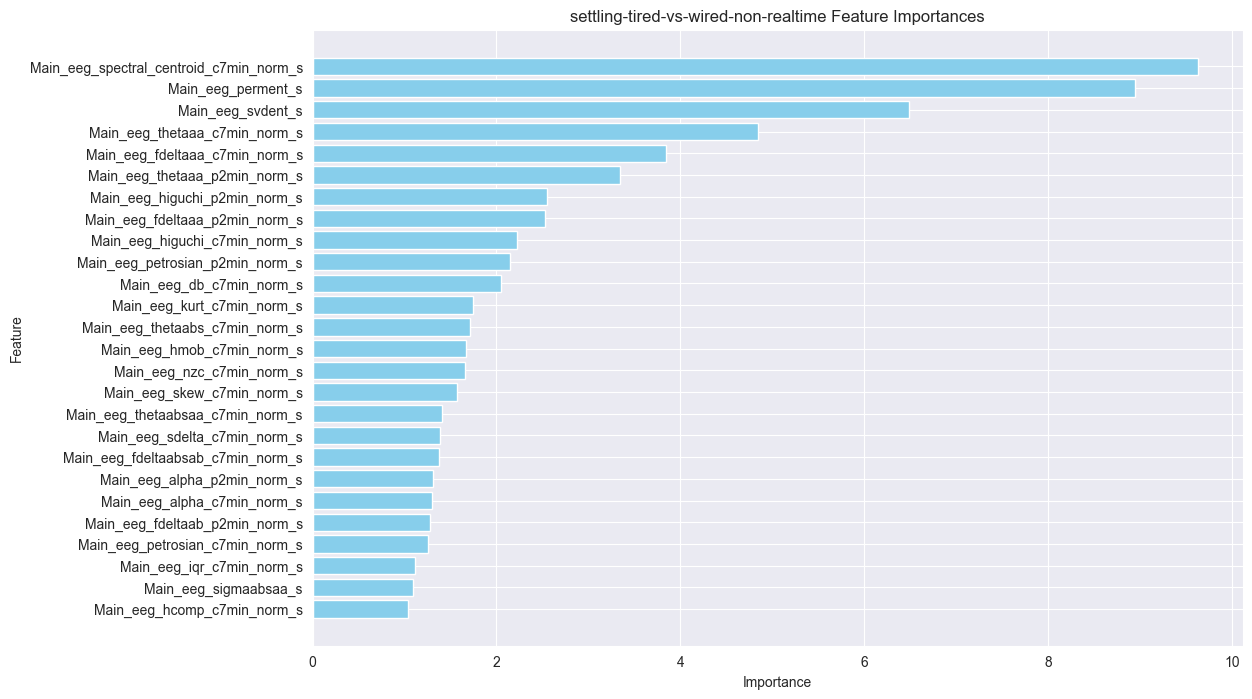

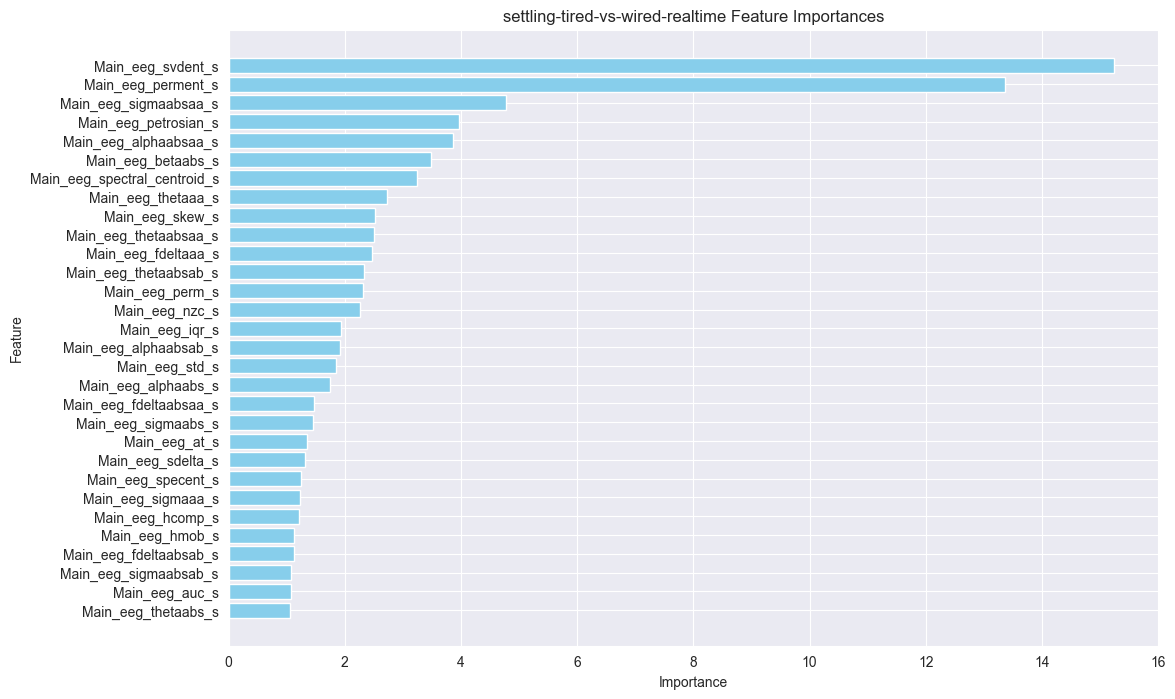

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

def importances(md: ModelAndData):
    # Get feature importances
    feature_importances = md.model.get_feature_importance()
    
    # Create a DataFrame to display the feature importances
    feature_names = md.X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })
    importance_df = importance_df[importance_df['Importance'] > 1]
    
    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    
    # Plot the feature importances
    plt.figure(figsize=(12, 8))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(md.name + ' Feature Importances')
    plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
    plt.show()

for md in models_and_data:
    importances(md)

# Save model

In [23]:
import dotenv
dotenv.load_dotenv()

import paramiko

# Configure logging
logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

def secure_copy_file(local_path, remote_path, hostname, username, password):
    # Create an SSH client
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    
    ssh.connect(hostname, username=username, password=password)

    # Open an SFTP session
    sftp = ssh.open_sftp()

    # Get the size of the file to be transferred
    file_size = os.path.getsize(local_path)

    # Define a callback function to show progress
    with tqdm(total=file_size, unit='B', unit_scale=True, desc=local_path) as pbar:
        def progress_callback(transferred, total):
            pbar.update(transferred - pbar.n)

        # Copy the file with progress callback
        sftp.put(local_path, remote_path, callback=progress_callback)

    # Close the SFTP session and SSH connection
    sftp.close()
    ssh.close()

hostname = os.getenv('SSH_HOST')
username = os.getenv('SSH_USERNAME')
password = os.getenv('SSH_PASSWORD')

for md in models_and_data:
    model_filename = f"{md.name}_catboost_model.cbm"
    md.model.save_model(model_filename)
    secure_copy_file(model_filename, '/home/graham/dev/Brainwave-Models/' + model_filename, hostname, username, password)

print("Copied all files")

settling-tired-vs-wired-non-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 2.51MB/s]
settling-tired-vs-wired-realtime_catboost_model.cbm: 100%|██████████| 2.24M/2.24M [00:00<00:00, 3.05MB/s]

Copied all files
